## LETKF
- 計算量は多くなるが並列計算できる．

### アルゴリズム
$ \tilde{P^a} = [(N-1)I/\rho + dY^T R^{-1} dY]^{-1} $

$ T = \tilde{P^a} dY^T R^{-1}(y^o - \overline{dY^f}) + [(N-1) \tilde{P^a}]^{1/2} $

$ X^a = x^f + dX^f T$

### localiztion
- 各点で分けて解析を行う．
- その際に

### Question
- 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%load_ext Cython

# モジュールの読み込み
import sys
sys.path.append('./module')
from utils import make_lorenz96, rk4, error_series_kf, plot_error_KF, estimate_error_with_params
from localization import plot_gaspari_cohn
from kalman_filters import LocalEnsembleTransformKalmanFilter as LETKF

/Users/sakajokenkyusitutakeda/.pyenv/versions/anaconda3-2020.02/envs/startup/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Lorenz96の設定
J = 40
F = 8
lorenz = make_lorenz96(F)

# 同化step
# 時間発展は0.01ごとに行う
dt = 0.05

# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# dtは同化step
def M(x, dt):
    for i in range(int(dt/0.01)):
        x = rk4(0, x, 0.01, lorenz)
    return x

# 単位行列
I = np.identity(J)

# 観測
H = I

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((J, J))

# 観測誤差共分散, 後で定数倍の変化をさせる.
R = I

# 観測値と真値
y = np.load('data/obs_atr.npy')
true = np.load('data/true_atr.npy')

# KFの初期値
np.random.seed(0)
x_0 = true[np.random.randint(len(true)-1)]
P_0 = 25*I

In [61]:
# %%cython
import numpy as np
from numpy import sqrt, trace, zeros, identity, exp, random
from numpy.random import multivariate_normal, choice
from numpy.linalg import inv
import scipy
from scipy.linalg import sqrtm

import sys
sys.path.append('./module')
from localization import calc_dist, polynomial, gaspari_cohn
class LocalEnsembleTransformKalmanFilter:
    def __init__(self, M, H, Q, R, y, x_0, P_0, m=10, dt=0.05, alpha=1, c=3, localization='gaspari-cohn', addaptive=False):
        self.M = M
        self.H = H
        self.Q = Q
        self.R = R
        self.y = y
        self.m = m # アンサンブルメンバー数
        self.dt = dt
        
        # 実装で技術的に必要
        self.dim_x = Q.shape[0]
        self.I = identity(m)
        
        self.alpha = alpha # inflation用の定数
        self.addaptive = addaptive
        self.c = c
        self.localization = localization

        # filtering実行用
        self.x = [] # 記録用
        self.x_f = []
        self.trP = []

        self._initialize(x_0, P_0, m)

  #　初期状態
    def _initialize(self, x_0, P_0, m):
        random.seed(0)
        self.X = x_0 + multivariate_normal(np.zeros(self.dim_x), P_0, m) # (m, J)
        self.x_mean = self.X.mean(axis=0)
        self.dX = np.zeros((m, self.dim_x))
    
  # 逐次推定を行う
    def forward_estimation(self):
        for y_obs in self.y:
            self._forecast()
            self._update(y_obs)

    # 更新/解析
    def _update(self, y_obs):
        x_f = self.x_mean; X_f = self.X; I = self.I; H = self.H; R = self.R; m = self.m; alpha = self.alpha; N = self.dim_x

        dX_f = X_f - x_f # (m, N)
        dY = (H@dX_f.T).T # (m, dim_y)
        
        # TODO: adaptive inflationの計算場所
        if self.addaptive: # 不完全, 1/200乗すると20membeで0.1848が出た
            alpha = (trace((y_obs - dY).T@(y_obs - dY) - (m-1)*R)/trace(dY.T@dY))**(1/120)
            print(alpha)

        # x_iを推定．
        for i in range(self.dim_x):
            C = dY@(self._rho(i)*inv(R)) # localization: invRの各i行にrho_iをかける．(m, dim_y)

            P_at = inv(((m-1)/alpha)*self.I + C@dY.T) # アンサンブル空間でのP_a．(m, m)
            T = (P_at@C@(y_obs - H@x_f) + self.calc_sqrtm((m-1)*P_at)).T # 注:Pythonの使用上第１項(mean update)が行ベクトルとして足されているので転置しておく．(m, m)
            
            self.dX[:, i] =  (dX_f.T@T).T[:, i]
            # self.X[:, i] = x_f[i] + (dX_f.T@T).T[:, i] # (m, dim_x)
        self.X = x_f + self.dX
        
#         if self.addaptive: # 不完全
#             epsilon_af = (H@self.dX.T).T - dY
#             self.alpha = (trace((y_obs - dY).T@(y_obs - dY) - (m-1)*R)/trace(epsilon_af.T@epsilon_af))
#             print(self.alpha)
            
        # 記録: 更新した値のアンサンブル平均xを保存, 推定誤差共分散P_fのtraceを保存
        self.x.append(self.X.mean(axis=0))
        self.trP.append(sqrt(trace(dX_f.T@dX_f)/40))


    # 予報/時間発展
    def _forecast(self):
        # アンサンブルで x(k) 予測
        for i, s in enumerate(self.X):
            self.X[i] = self.M(s, self.dt)

        self.x_mean = self.X.mean(axis=0)
        self.x_f.append(self.x_mean)
     
    # localization用の関数
    def _rho(self, i):
        if self.localization=='gaussian':
            return np.array([exp(-calc_dist(i, j)**2/(2*(self.c*(0.3**(1/2)))**2)) for j in range(self.dim_x)]) # gaussian ver
        else:
            return np.array([gaspari_cohn(calc_dist(i, j), self.c) for j in range(self.dim_x)])

    def calc_sqrtm(self, mat):
        return self._symmetric(sqrtm(self._symmetric(mat)))
    
    def _symmetric(self, S):
        return 0.5*(S + S.T)

1.0062840722221653
1.0353722029147538
1.0388343509275888
1.0422330567053473
1.0438812033500915
1.0446804448057456
1.0457103761519302
1.0458072052265452
1.0460148617844336
1.0472078882560156
1.047283188132606
1.0464304941743114
1.0472096892670457
1.047074835123866
1.047506941297442
1.0459730235211988
1.0466759711159177
1.0475291704661123
1.0481233123582716
1.0485791364472588
1.0492510433726976
1.049319400055867
1.0497642527215656
1.0507136230813683
1.0491154137850571
1.0506384424519706
1.05004561405707
1.0494255222400803
1.0495178125855398
1.0500731445834766
1.0508191594272902
1.0490262173876865
1.0502060625542053
1.0502758053246586
1.0510354125220336
1.050956101130535
1.0510412237395494
1.0512028431382907
1.0507314809520514
1.0497920973373212
1.0494117832551402
1.0503606293172278
1.0496754263349388
1.0484833325779295
1.0494325613247144
1.0497928108057244
1.0499178745135822
1.048930748695143
1.0503273624733669
1.049340260389591
1.0487213019972228
1.050655936544611
1.0506396062811327
1.0

1.0520685145768356
1.0521969807914489
1.052285429805609
1.050931708830258
1.0518447239348327
1.0518073971240607
1.051768765724549
1.0512042280811427
1.0515895008216278
1.0510205642262935
1.0509441665552588
1.0499741580219055
1.0516552615693828
1.051083604028421
1.0504396041277066
1.0510815289753683
1.0513214951198082
1.0497766790665928
1.051889385803895
1.0524409166399118
1.052223525970631
1.054135356714143
1.0552436291406475
1.0538631991645633
1.0537004188499195
1.054212946174764
1.054621513862894
1.054315224542033
1.0538154969361933
1.0537755304596537
1.053647161518418
1.052782384966039
1.0533343203092145
1.051698342121099
1.0506710371426984
1.050503979922227
1.0512074474792328
1.0508256922058756
1.0506492922416522
1.051976499919352
1.0509749554982908
1.0519226905338601
1.0528130009130736
1.0530556016450434
1.052342163089273
1.0524108626958302
1.0527690074156846
1.0512377652455582
1.051110598497078
1.0506505046145551
1.0495712307902614
1.0495325324227363
1.049668296582241
1.050479832

1.0505256948160075
1.0515777583305523
1.0506462646644976
1.0506039758848962
1.0503749621531988
1.0507317774392313
1.0510140598630069
1.049175733757278
1.0502357879637838
1.0505725445343896
1.0497965312547448
1.0500078951998983
1.0487330203069074
1.0502449771306082
1.0486776115790537
1.0502475615294167
1.0488526682959751
1.0499402510096325
1.0502711861670109
1.049460170837299
1.0500136778245137
1.049993186178668
1.0502149928139655
1.052636658710719
1.052750283648514
1.0512115370587536
1.0521803176929134
1.0525641486461177
1.052027544529054
1.0518351177455905
1.0520764628114276
1.0520174017912158
1.0522394356155382
1.0507966728455091
1.0509799211664033
1.0501952128315426
1.0513937087901963
1.0517420184844726
1.0512157178065926
1.0514941137927256
1.0511739421786617
1.0502900915714102
1.0509719937461435
1.0505996216628628
1.0504992910535362
1.0506509672439641
1.0504784913032081
1.051402103812435
1.0512781005373415
1.050936049278806
1.0509809158536636
1.0501030777662037
1.0496905505449858
1

1.050198081444604
1.0510967489817062
1.0492826746280919
1.050542835726712
1.050758035485547
1.051027447318105
1.0506308647936162
1.0492568634359085
1.0492272980968504
1.0487612754130724
1.0483607494935743
1.0501966981338533
1.048293602654837
1.0488468618672215
1.0502691423786135
1.050775281527989
1.0501286320330054
1.0508284227415823
1.051741180529427
1.0509134255184787
1.0512326193466544
1.0523019557825282
1.0525509482669446
1.0515055082806775
1.0519028877254903
1.05056615716301
1.0520550417786605
1.05261088434332
1.0540447887941207
1.0531077044536756
1.0530996686957894
1.0535884190399318
1.0524962988818616
1.0532888640252853
1.0532253679297183
1.053006632092025
1.0526302993093535
1.0525419403241763
1.054583441113068
1.054163195235666
1.0534349459744545
1.0528300821777727
1.05290111530875
1.0532970350121509
1.0519317384491205
1.0516066766394727
1.0505288796988297
1.0516995691078912
1.0517140862612355
1.0533316835907083
1.0524128975568108
1.0521143797057129
1.05250419531003
1.050911987

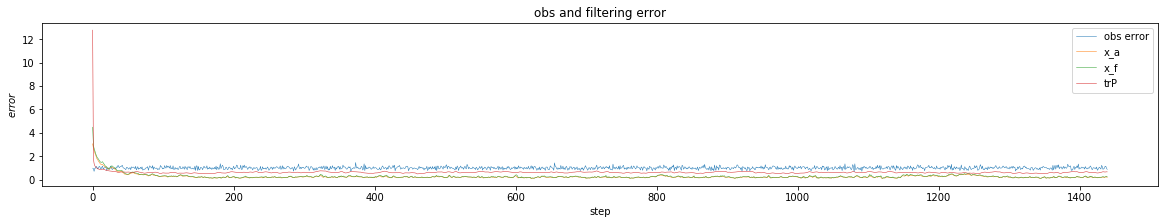

9.15
CPU times: user 7min 32s, sys: 4.44 s, total: 7min 36s
Wall time: 57.3 s


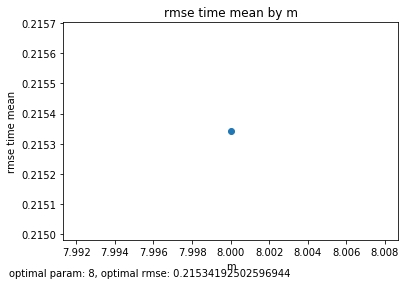

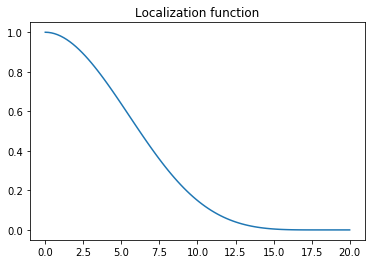

In [63]:
%%time
m = 8
alpha = 1.05
# sigma = 4.5
# c = sigma*(0.3**(-1/2))
c = 9.15
letkf = LocalEnsembleTransformKalmanFilter(M, H, Q, R, y[:], x_0, P_0, m=m, alpha=alpha, c=c, localization='', addaptive=True)
letkf.forward_estimation()
plot_error_KF(true, y, [letkf.x, letkf.x_f], trPs=[letkf.trP], legends=['x_a', 'x_f'])
_, _, rmse = estimate_error_with_params(true, [letkf.x], [m], 'm')
# df = pd.read_csv('data/kf_time_rmse_comparision.csv', index_col=0, header=0)
plot_gaspari_cohn(c)
print(c)

## Gaspari Cohn
- $ 2c $で$0$になる．
- 対応するgassianのスケールは$L = c(0.3)^{1/2}$(標準偏差$ L = c(0.3)^2 $のgaussianに対応．)

### gaspari cohn vs gaussian
パラメータの対応関係．以下の対応がある．

$ G_c(x, c) \leftrightarrow \exp(- \frac{x^2}{2L^2}) $

ただし，$ L = c(0.3)^{1/2} $

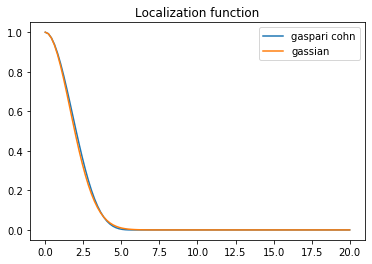

In [44]:
c = c
L = c*(0.3)**(1/2)
plot_gaspari_cohn(c)
x_arr = np.linspace(0, 20, 100)
y_func = [np.exp(-x**2/(2*L**2)) for x in x_arr]
plt.plot(x_arr, y_func, label='gassian')
plt.legend()

## parameter推定
推定20min程度 -> 結果: 21min46s

In [41]:
# %%time
# m=8
# spin_up = 150
# duration = 150

# num_alpha = 11
# num_c = 10
# params_alpha = np.linspace(1.0, 1.5, num=num_alpha)
# params_c = np.arange(num_c) + 1
# errors = np.zeros((num_alpha, num_c))

# for i in range(num_alpha):
#     alpha = params_alpha[i]
#     for j in range(num_c):
#         c = params_c[j]
#         letkf = LETKF(M, H, Q, R, y[:spin_up+duration], x_0, P_0, m=m, alpha=alpha, c=c)
#         letkf.forward_estimation()
#         error = error_series_kf(true, letkf.x, time_index=np.arange(duration)+spin_up).mean()
#         errors[i,j] = error
#         print('complete: alpha: {}, c: {}, error: {}'.format(alpha, c, error))
#     print('=======================')
# df = pd.DataFrame(errors, index=params_alpha, columns=params_c)
# df.to_csv('data/letkf/letkf_alpha_c_rough.csv')

Text(42.0, 0.5, 'alpha')

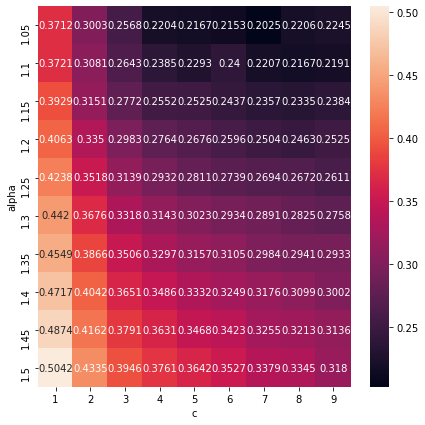

In [25]:
df = pd.read_csv('data/letkf/letkf_alpha_c_rough.csv', index_col=0, header=0)
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(df.iloc[1:, :9], annot=True, fmt='.4g')
ax.set_xlabel('c')
ax.set_ylabel('alpha')

### 細かく調整
実行時間: 1h 40min 28s

In [4]:
# # %%time
# m=8
# spin_up = 200
# duration = len(true) - spin_up

# num_alpha = 11
# num_c = 11
# params_alpha = np.linspace(1.05-0.05, 1.05+0.05, num=num_alpha)
# params_c = np.arange(num_c)*(2/5) + 6
# errors = np.zeros((num_alpha, num_c))

# for i in range(num_alpha):
#     alpha = params_alpha[i]
#     for j in range(num_c):
#         c = params_c[j]
#         letkf = LETKF(M, H, Q, R, y[:spin_up+duration], x_0, P_0, m=m, alpha=alpha, c=c)
#         letkf.forward_estimation()
#         error = error_series_kf(true, letkf.x, time_index=np.arange(duration)+spin_up).mean()
#         errors[i,j] = error
#         print('complete: alpha: {}, c: {}, error: {}'.format(alpha, c, error))
#     print('=======================')
# df = pd.DataFrame(errors, index=params_alpha, columns=params_c)
# df.to_csv('data/letkf/letkf_alpha_c_detail.csv')

complete: alpha: 1.0, c: 6.0, error: 2.499304214331703
complete: alpha: 1.0, c: 6.4, error: 2.7021218102087072
complete: alpha: 1.0, c: 6.8, error: 3.7140541820978297
complete: alpha: 1.0, c: 7.2, error: 3.7766673085106484
complete: alpha: 1.0, c: 7.6, error: 3.6067107499367226
complete: alpha: 1.0, c: 8.0, error: 3.8879654453336117
complete: alpha: 1.0, c: 8.4, error: 3.776763743894956
complete: alpha: 1.0, c: 8.8, error: 3.737868434132983
complete: alpha: 1.0, c: 9.2, error: 3.8044488419319085
complete: alpha: 1.0, c: 9.6, error: 4.170856864294661
complete: alpha: 1.0, c: 10.0, error: 3.8007276181629903
complete: alpha: 1.01, c: 6.0, error: 0.23291298796983564
complete: alpha: 1.01, c: 6.4, error: 0.2191995837961539
complete: alpha: 1.01, c: 6.8, error: 1.3307709078288619
complete: alpha: 1.01, c: 7.2, error: 2.9608246593733356
complete: alpha: 1.01, c: 7.6, error: 3.4781966449821415
complete: alpha: 1.01, c: 8.0, error: 3.700222023670594
complete: alpha: 1.01, c: 8.4, error: 3.60328

Text(69.0, 0.5, 'alpha')

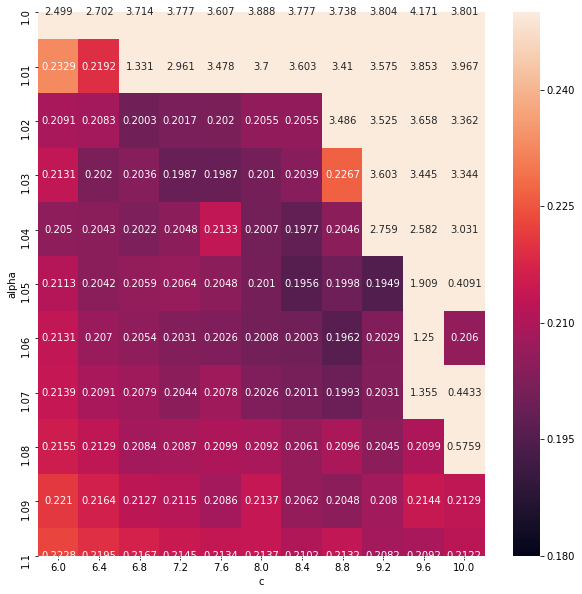

In [13]:
df = pd.read_csv('data/letkf/letkf_alpha_c_detail.csv', index_col=0, header=0)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.iloc[:, :], annot=True, fmt='.4g', vmax=0.25, vmin=0.18)
ax.set_xlabel('c')
ax.set_ylabel('alpha')

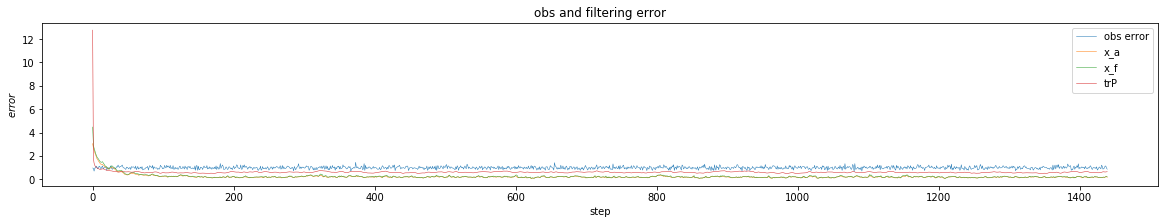

9.15
CPU times: user 6min 49s, sys: 1.58 s, total: 6min 51s
Wall time: 51.5 s


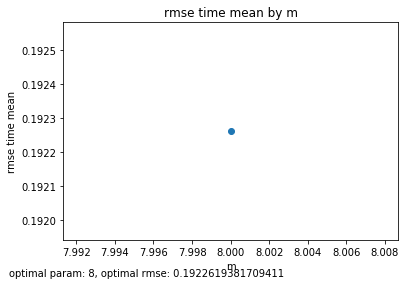

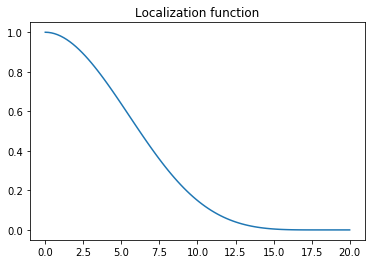

In [49]:
%%time
m = 8
alpha = 1.05
# sigma = 4.5
# c = sigma*(0.3**(-1/2))
c = 9.15
letkf = LETKF(M, H, Q, R, y[:], x_0, P_0, m=m, alpha=alpha, c=c, localization='', addaptive=False)
letkf.forward_estimation()
plot_error_KF(true, y, [letkf.x, letkf.x_f], trPs=[letkf.trP], legends=['x_a', 'x_f'])
_, _, rmse = estimate_error_with_params(true, [letkf.x], [m], 'm')
plot_gaspari_cohn(c)
print(c)

# 記録更新
df = pd.read_csv('data/kf_time_rmse_comparision.csv', index_col=0, header=0)
if df['LETKF8']['rmse'] > rmse:
    df['LETKF8']['rmse'] = rmse
    print('updated!')
    df.to_csv('data/kf_time_rmse_comparision.csv')

In [56]:
df = pd.read_csv('data/kf_time_rmse_comparision.csv', index_col=0, header=0)
df


,ExKF,3DVar,PO40,SRF20,SRF40,SRF50,LETKF8
time,49.6000,1.4900,51.9000,23.9000,53.2000,122.0000,51.500000
rmse,0.2018,0.3871,0.2705,0.2099,0.1636,0.1679,0.192262


In [41]:
# np.save('data/letkf/letkf_optimal.npy', [letkf.x, letkf.trP])

In [ ]:
# # %%time
# m=8
# spin_up = 200
# duration = len(true) - spin_up

# num_alpha = 11
# num_c = 11
# params_alpha = np.linspace(1.05-0.05, 1.05+0.05, num=num_alpha)
# params_c = np.arange(num_c)*(2/5) + 6
# errors = np.zeros((num_alpha, num_c))

# for i in range(num_alpha):
#     alpha = params_alpha[i]
#     for j in range(num_c):
#         c = params_c[j]
#         letkf = LETKF(M, H, Q, R, y[:spin_up+duration], x_0, P_0, m=m, alpha=alpha, c=c)
#         letkf.forward_estimation()
#         error = error_series_kf(true, letkf.x, time_index=np.arange(duration)+spin_up).mean()
#         errors[i,j] = error
#         print('complete: alpha: {}, c: {}, error: {}'.format(alpha, c, error))
#     print('=======================')
# df = pd.DataFrame(errors, index=params_alpha, columns=params_c)
# df.to_csv('data/letkf/letkf_alpha_c_detail.csv')